In [28]:
import os.path
import os
os.chdir("../")
%run config.ipynb
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

In [29]:
eTraffic = pd.read_csv(os.path.join(root, 'eTraffic_lag3.csv'))
print(eTraffic.shape)
print(len(eTraffic['local_authority_name'].unique()))

(1273, 17)
67


In [30]:
eTraffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   local_authority_name          1273 non-null   object 
 1   year                          1273 non-null   int64  
 2   pedal_cycles                  1273 non-null   float64
 3   two_wheeled_motor_vehicles    1273 non-null   float64
 4   cars_and_taxis                1273 non-null   float64
 5   buses_and_coaches             1273 non-null   float64
 6   LGVs                          1273 non-null   float64
 7   HGVs_2_rigid_axle             1273 non-null   float64
 8   HGVs_3_rigid_axle             1273 non-null   float64
 9   HGVs_4_or_more_rigid_axle     1273 non-null   float64
 10  HGVs_3_or_4_articulated_axle  1273 non-null   float64
 11  HGVs_5_articulated_axle       1273 non-null   float64
 12  HGVs_6_articulated_axle       1273 non-null   float64
 13  all

In [31]:
eTraffic.head()

,local_authority_name,year,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,all_HGVs,all_motor_vehicles,GDP,local_authority_name_encoded
0,Barnet,2001,1602.0,15907.0,735493.0,11038.0,129137.0,23599.0,2599.0,3235.0,2498.0,3951.0,3184.0,39066.0,930641.0,66.5,0
1,Barnet,2002,1895.0,16269.0,726567.0,12326.0,127527.0,22825.0,2706.0,3184.0,2480.0,3790.0,3362.0,38347.0,921036.0,68.5,0
2,Barnet,2003,1393.0,15282.0,774985.0,10245.0,121795.0,21971.0,3013.0,3960.0,2053.0,4002.0,3305.0,38304.0,960611.0,70.1,0
3,Barnet,2004,1626.0,11552.0,585697.0,10064.0,96435.0,14035.0,2158.0,3163.0,1773.0,2725.0,2198.0,26052.0,729800.0,71.4,0
4,Barnet,2005,1919.0,15356.0,731251.0,12411.0,126300.0,19454.0,3301.0,3380.0,2182.0,4052.0,3822.0,36192.0,921510.0,73.9,0


## Select Feature and Model

In [32]:
eTraffic = eTraffic[eTraffic['year'] < 2020]
print(eTraffic['year'].min(), eTraffic['year'].max())
print(eTraffic.shape)

2001 2019
(1273, 17)


In [33]:
X = eTraffic.drop(columns=['GDP', 'year', 'local_authority_name', 'local_authority_name_encoded'])
y = eTraffic['GDP']
print(X.shape, y.shape)

(1273, 13) (1273,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

In [48]:
param_dist = {
    'n_estimators': np.arange(20, 100, step=5),
    'max_depth': np.arange(3, 12, step=1),
    'min_samples_split': np.arange(3, 12, step=1),
    'min_samples_leaf': np.arange(2, 12, step=1),
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=18)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=40, cv=3, scoring='r2', random_state=18)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 11, 'bootstrap': True}
Best score: 0.5159805376083842


In [36]:
# train set
Y_train_hat = random_search.best_estimator_.predict(X_train)
mse_train = mean_squared_error(y_train, Y_train_hat)
mae_train = mean_absolute_error(y_train, Y_train_hat)
mape_train = mean_absolute_percentage_error(y_train, Y_train_hat)
r2_train = r2_score(y_train, Y_train_hat)

# test set
Y_test_hat = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test, Y_test_hat)
mae_test = mean_absolute_error(y_test, Y_test_hat)
mape_test = mean_absolute_percentage_error(y_test, Y_test_hat)
r2_test = r2_score(y_test, Y_test_hat)

print(f"[RF][Training Set] MSE: {mse_train:.2f}; MAPE: {mape_train:.2f}; MAE: {mae_train:.2f}; R2 score: {r2_train:.2f}")
print(f"[RF][Testing Set]  MSE: {mse_test:.2f}; MAPE: {mape_test:.2f}; MAE: {mae_test:.2f}; R2 score: {r2_test:.2f}")

feature_importances = random_search.best_estimator_.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

features_df

[RF][Training Set] MSE: 23.15; MAPE: 0.04; MAE: 3.33; R2 score: 0.80
[RF][Testing Set]  MSE: 62.05; MAPE: 0.07; MAE: 5.63; R2 score: 0.54


,Feature,Importance
8,HGVs_3_or_4_articulated_axle,0.246125
10,HGVs_6_articulated_axle,0.210989
5,HGVs_2_rigid_axle,0.166604
7,HGVs_4_or_more_rigid_axle,0.086404
3,buses_and_coaches,0.053961
4,LGVs,0.050546
0,pedal_cycles,0.042226
1,two_wheeled_motor_vehicles,0.037424
6,HGVs_3_rigid_axle,0.032908
9,HGVs_5_articulated_axle,0.025774


### Select features with cumulative importance in the top 85%

In [37]:
features_df['Cumulative Importance'] = features_df['Importance'].cumsum()

selected_features = features_df[features_df['Cumulative Importance'] <= 0.85]['Feature']
print(f"Selected Features number: {len(selected_features)}")
print(f"Selected Features: \n{selected_features}")

Selected Features number: 6
Selected Features: 
8     HGVs_3_or_4_articulated_axle
10         HGVs_6_articulated_axle
5                HGVs_2_rigid_axle
7        HGVs_4_or_more_rigid_axle
3                buses_and_coaches
4                             LGVs
Name: Feature, dtype: object


## Retrain the model using selected features

In [38]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(X_train_selected.shape, X_test_selected.shape)
print(X_train_selected.columns)

(1018, 6) (255, 6)
Index(['HGVs_3_or_4_articulated_axle', 'HGVs_6_articulated_axle',
       'HGVs_2_rigid_axle', 'HGVs_4_or_more_rigid_axle', 'buses_and_coaches',
       'LGVs'],
      dtype='object')


In [39]:
# modeling
param_dist = {
    'n_estimators': np.arange(20, 80, step=5),
    'max_depth': np.arange(3, 10, step=1),
    'min_samples_split': np.arange(3, 10, step=1),
    'min_samples_leaf': np.arange(2, 10, step=1),
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=18)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='r2', random_state=18)
random_search.fit(X_train_selected, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

rf_best = random_search.best_estimator_

# test set
Y_test_hat = rf_best.predict(X_test_selected)
mse_test = mean_squared_error(y_test, Y_test_hat)
mae_test = mean_absolute_error(y_test, Y_test_hat)
mape_test = mean_absolute_percentage_error(y_test, Y_test_hat)
r2_test = r2_score(y_test, Y_test_hat)

# train set
Y_train_hat = rf_best.predict(X_train_selected)
mse_train = mean_squared_error(y_train, Y_train_hat)
mae_train = mean_absolute_error(y_train, Y_train_hat)
mape_train = mean_absolute_percentage_error(y_train, Y_train_hat)
r2_train = r2_score(y_train, Y_train_hat)

print(f"[RF][Training Set] MSE: {mse_train:.2f}; MAPE: {mape_train:.2f}; MAE: {mae_train:.2f}; R2 score: {r2_train:.2f}")
print(f"[RF][Testing Set]  MSE: {mse_test:.2f}; MAPE: {mape_test:.2f}; MAE: {mae_test:.2f}; R2 score: {r2_test:.2f}")

Best parameters: {'n_estimators': 40, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 9, 'bootstrap': True}
Best score: 0.49515663069079946
[RF][Training Set] MSE: 20.90; MAPE: 0.04; MAE: 3.17; R2 score: 0.82
[RF][Testing Set]  MSE: 64.33; MAPE: 0.07; MAE: 5.73; R2 score: 0.52


### Grid search in a small range base on privous parameters

In [56]:
best_model = random_search.best_params_
# param_grid = {
#     'n_estimators': np.arange(-10, 10, step=3) + best_model['n_estimators'],  # 树的数量
#     'max_depth': np.arange(-2, 2, step=3) + best_model['max_depth'],  # 树的最大深度
#     'min_samples_split': np.arange(2, 4, step=2) + best_model['min_samples_leaf'],  # 节点分裂所需的最小样本数
#     'min_samples_leaf': np.arange(2, 4, step=2) + best_model['min_samples_leaf'],
#     'bootstrap': [best_model['bootstrap']]
# }

param_grid = {
    'n_estimators': [10, 15, 20],
    'max_depth': [8],
    'min_samples_split': [16, 20, 25],
    'min_samples_leaf': [16, 20, 25],
    'bootstrap': [True]
}

rf = RandomForestRegressor(random_state=18)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, scoring='r2')
grid_search.fit(X_train_selected, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# train set
Y_train_hat = grid_search.best_estimator_.predict(X_train_selected)
mse_train = mean_squared_error(y_train, Y_train_hat)
mae_train = mean_absolute_error(y_train, Y_train_hat)
mape_train = mean_absolute_percentage_error(y_train, Y_train_hat)
r2_train = r2_score(y_train, Y_train_hat)

# test set
Y_test_hat = grid_search.best_estimator_.predict(X_test_selected)
mse_test = mean_squared_error(y_test, Y_test_hat)
mae_test = mean_absolute_error(y_test, Y_test_hat)
mape_test = mean_absolute_percentage_error(y_test, Y_test_hat)
r2_test = r2_score(y_test, Y_test_hat)

print(f"[RF][Training Set] MSE: {mse_train:.2f}; MAPE: {mape_train:.2f}; MAE: {mae_train:.2f}; R2 score: {r2_train:.2f}")
print(f"[RF][Testing Set]  MSE: {mse_test:.2f}; MAPE: {mape_test:.2f}; MAE: {mae_test:.2f}; R2 score: {r2_test:.2f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=16, min_samples_split=16, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=16, min_samples_split=16, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=16, min_samples_split=16, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=16, min_samples_split=16, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=16, min_samples_split=16, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=16, min_samples_split=16, n_estimators=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=16, min_samples_split=16, n_estimators=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=16, min_samples_split=16, n_estimators=15; total time=   0.0s
[C

In [41]:
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances.shape)
print(X_train_selected.shape)
features_df = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

features_df

(6,)
(1018, 6)


,Feature,Importance
0,HGVs_3_or_4_articulated_axle,0.293371
1,HGVs_6_articulated_axle,0.262176
2,HGVs_2_rigid_axle,0.210846
3,HGVs_4_or_more_rigid_axle,0.106001
5,LGVs,0.070631
4,buses_and_coaches,0.056976


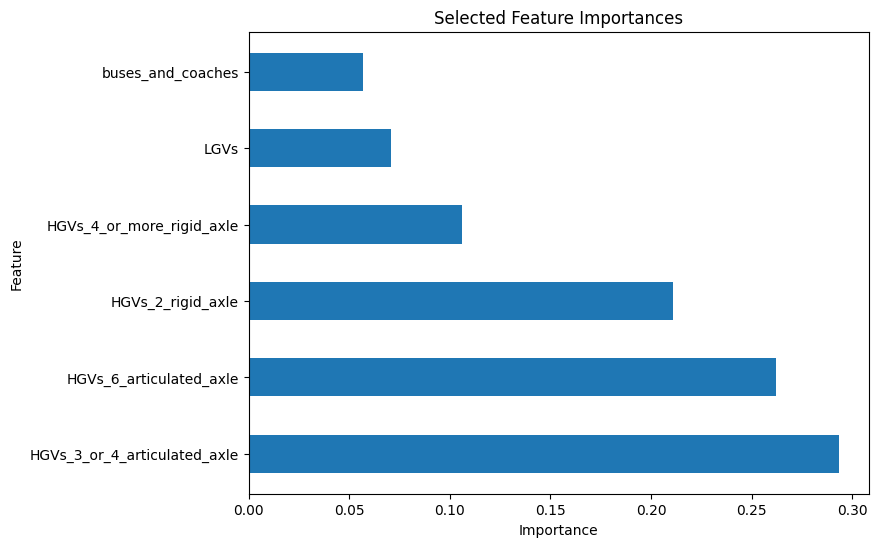

In [42]:
# plot importance of features
plt.figure(figsize=(8, 6))
plt.bar(x=0, bottom=features_df['Feature'],
        height=0.5, width=features_df['Importance'], orientation='horizontal')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Selected Feature Importances')
plt.show()

As we have found the important features:
- HGVs_3_or_4_articulated_axle
- HGVs_6_articulated_axle
- LGVs
- HGVs_2_rigid_axle
- HGVs_4_or_more_rigid_axle
